In [3]:
import pandas as pd
import pickle

In [4]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager

from pathlib import Path

import matplotlib as mpl

from matplotlib.patches import Patch
from matplotlib.lines import Line2D



fpath = Path(mpl.get_data_path(), "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")


from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
plt.rcParams['figure.dpi'] = 300
font_path = "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf"
font_manager.fontManager.addfont("/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['svg.fonttype']='none'

## SI table I: searched datasets
outputs a table of searched genomes and associated taxonomic labels, separated by refseq/genbank

In [18]:
##load a dataframe of genome taxids from genome accessions
df1=pd.read_csv('Data/genbank_genomes_4_22_2025.tsv',sep='\t')
df2=pd.read_csv('Data/refseq_genomes_scaffold_plus_4_19_2025.tsv',sep='\t')
dftax=pd.concat([df1,df2]).set_index('Assembly Accession')
# dftax.loc['GCF_006496715.1',['Organism Name','Organism Taxonomic ID']]=['Aedes albopictus',7160]

In [20]:
## fill in additional taxonomic info
from ete3 import NCBITaxa


ncbi = NCBITaxa()

for index, row in dftax.iterrows():
    taxid = int(row['Organism Taxonomic ID'])
    
    try:
        # Get lineage
        lineage = ncbi.get_lineage(taxid)
        
        # Get ranks for lineage
        ranks = ncbi.get_rank(lineage)
        
        # Get names for lineage (optional, if you want names instead of IDs)
        names = ncbi.get_taxid_translator(lineage)
        
        # Extract class and order
        class_name = None
        order_name = None
        for lin_taxid in lineage:
            if ranks.get(lin_taxid) == 'class':
                class_name = names.get(lin_taxid, None)
            elif ranks.get(lin_taxid) == 'order':
                order_name = names.get(lin_taxid, None)

        # Assign to DataFrame
        dftax.loc[index, 'class'] = class_name
        dftax.loc[index, 'order'] = order_name
        dftax.loc[index, 'lineage'] = str({ranks[x]:names[y] for x,y in zip(ranks,names)})

    except Exception as e:

        print(f"Failed to process taxid {taxid}: {e}")

/n/home11/rkapoor/.conda/envs/rishabh/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Failed to process taxid 3402493: 3402493 taxid not found


In [21]:
## manually fill in data for a missing species in the ete3 database
index='GCA_927349885.1'
taxid=294691
lineage = ncbi.get_lineage(taxid)

# Get ranks for lineage
ranks = ncbi.get_rank(lineage)

# Get names for lineage (optional, if you want names instead of IDs)
names = ncbi.get_taxid_translator(lineage)

# Extract class and order
class_name = None
order_name = None
for lin_taxid in lineage:
    if ranks.get(lin_taxid) == 'class':
        class_name = names.get(lin_taxid, None)
    elif ranks.get(lin_taxid) == 'order':
        order_name = names.get(lin_taxid, None)

# Assign to DataFrame
dftax.loc[index, 'class'] = class_name
dftax.loc[index, 'order'] = order_name
dftax.loc[index, 'lineage'] = str({ranks[x]:names[y] for x,y in zip(ranks,names)})

In [17]:
!mkdir 'SI tables'
dftax[dftax.index.str.contains('GCF_')].loc[:,['Assembly Name',
 'Organism Name',
 'Organism Taxonomic ID',
 'order',
 'class',
 'Assembly Level',
 'Assembly Release Date',
 'WGS project accession',
 'Assembly Stats Number of Scaffolds',
 'Annotation BUSCO Complete',
 'Annotation BUSCO Lineage']].to_csv('SI tables/SI table 1_RefSeq.tsv',sep='\t')

In [19]:
dftax[~dftax.index.str.contains('GCF_')].loc[:,['Assembly Name',
 'Organism Name',
 'Organism Taxonomic ID',
 'order',
 'class',
 'Assembly Level',
 'Assembly Release Date']].to_csv('SI tables/SI table 1_Genbank.tsv',sep='\t')

In [142]:
##add old aedes albopictus genome back, which was used for the secondary chimera XP_029735553.1
dftax.loc['GCF_006496715.1',['Organism Name','Organism Taxonomic ID']]=['Aedes albopictus',7160]
dftax.loc['GCF_006496715.1',['order','class']]=['Diptera','Insecta']

## SI table 4: chimera clusters
Output a dataframe of primary representative chimeras confirmed by phylogenetics in both metazoan and HGT intervals, along with associated interval annotations and taxonomic information

In [25]:
## load dictionary mapping of primary to secondary chimera mapping
file_path = 'outputs/secondary_chimera_adjacency_list.pickle'
with open(file_path, 'rb') as file:
    secondary_chimera_adjacency_list=pickle.load(file)

In [21]:
from Bio import SeqIO
##load fasta with chimeras from the previous iteration to prioritize in selection of representative sequences per cluster
og = SeqIO.to_dict(SeqIO.parse('outputs/previous_iteration_chimeras.fa', 'fasta'))


In [32]:
## load manual inspection results for HGT trees (note--only metazoan intervals from HGT-confirmed trees were inspected)

hgt=pd.read_csv("Tree_manual_inspection_HGT.tsv",sep='\t',index_col=0)
hgt=hgt[hgt.Tree_annot=='Yes']
hgt['gene']=[";".join(x.split(";")[0:2]) for x in hgt.index]

In [27]:
## load manual inspection results for metazoan trees (note--only metazoan intervals from HGT-confirmed trees were inspected)
meta=pd.read_csv("Tree_manual_inspection_Metazoan.tsv",sep='\t',index_col=0)
meta=meta[meta.Tree_annot=='Yes']
meta['gene']=[";".join(x.split(";")[0:2]) for x in meta.index]



In [29]:
from ete3 import NCBITaxa


ncbi = NCBITaxa()          

def lowest_common_rank(taxids, ncbi_obj=ncbi):
    """
    Return the (taxid, scientific name, rank) of the deepest/commonest rank
    that all input NCBI taxids share.

    Parameters
    ----------
    taxids : Iterable[int]
        A sequence or set of NCBI taxonomy IDs (e.g. {9606, 10090, 9598}).
    ncbi_obj : ete3.NCBITaxa, optional
        Pre-instantiated NCBITaxa object (default: the module-level `ncbi`).

    Returns
    -------
    tuple (int, str, str)
        taxid, scientific name, and rank of the lowest common ancestor (LCA).

    Raises
    ------
    ValueError
        If `taxids` is empty or no common ancestor is found (shouldn’t happen
        unless an ID is not in the database).
    """
    taxids = list({int(t) for t in taxids})   # unique & cast to int
    if not taxids:
        raise ValueError("`taxids` must contain at least one ID")

    # Full lineage (root → leaf) for each taxid
    lineages = []
    for x in taxids:
        try:
            lineages.append(ncbi_obj.get_lineage(x))
        except:
            print(x)

    # All ancestors common to every lineage
    common = set(lineages[0]).intersection(*lineages[1:])
    if not common:
        raise ValueError("No common ancestor found – check the taxids.")

    # Depth of each ancestor in the first lineage: 0=root, larger=deeper
    depth = {tax: idx for idx, tax in enumerate(lineages[0])}

    # Pick the common taxon that’s deepest in the tree
    lca_taxid = max(common, key=lambda t: depth[t])

    # Translate to name and rank
    name = ncbi_obj.get_taxid_translator([lca_taxid])[lca_taxid]
    rank = ncbi_obj.get_rank([lca_taxid])[lca_taxid]

    return lca_taxid, name, rank


In [60]:
##create dataframe
df=pd.DataFrame()
for x in list(meta.gene):

    ## fill in taxonomic information
    x_species=dftax.loc[x.split(";")[0],'Organism Name']
    x_taxid=dftax.loc[x.split(";")[0],'Organism Taxonomic ID']
    species=set([dftax.loc[xi.split(";")[0],'Organism Name'] for xi in secondary_chimera_adjacency_list[x] if xi.split(";")[0] in dftax.index ])
    ## fill in taxids of secondary chimeras
    taxids=list(set([int(dftax.loc[xi.split(";")[0],'Organism Taxonomic ID']) for xi in secondary_chimera_adjacency_list[x] if xi.split(";")[0] in dftax.index ]))

    order_dist=set(set([dftax.loc[xi.split(";")[0],'order'] for xi in secondary_chimera_adjacency_list[x] if xi.split(";")[0] in dftax.index ]))
    class_dist=set(set([dftax.loc[xi.split(";")[0],'class'] for xi in secondary_chimera_adjacency_list[x] if xi.split(";")[0] in dftax.index ]))
    
    try:
        ## fill in the lowest common taxonomic rank of the secondary chimeras
        span_taxid,span_name,span_rank=lowest_common_rank(taxids)

    except:
        print(x)
    df.loc[x,['q_species','q_taxid','n_species','span_taxid','span_name','span_rank','order_dist','class_dist','all_species','all_chimera_sequences']]=x_species, x_taxid, len(species), span_taxid,span_name,span_rank,order_dist,class_dist,str(set(species)),str(set(secondary_chimera_adjacency_list[x]))
    
df=df.sort_values('n_species',ascending=False)      
df.q_taxid=df.q_taxid.astype(int)

3402493


In [61]:
## Add phylogenetically confirmed intervals
for index, row in df.iterrows():
    df.loc[index,'HGT_intervals']=str([str(x.split("_")[-1]) for x in hgt[hgt.gene==index].index]).replace("'","")
    df.loc[index,'Meta_intervals']=str([str(x.split("_")[-1]) for x in meta[meta.gene==index].index]).replace("'","")

In [62]:
df['q_name']=df.index
df['cluster_id']=list(range(df.shape[0]))
df=df.set_index('cluster_id')
df.index=[x+1 for x in df.index]
df.index.name='cluster_id'


In [4]:

df=pd.read_csv("SI tables/SI table 4.tsv",sep="\t")
df['q_name']=[x.split(";")[1] for x in df.q_name]
df.to_csv("SI tables/SI table 4.tsv",sep="\t")

## Figure 1F: species/chimera

In [37]:
df=pd.read_csv("SI tables/SI table 4.tsv",sep="\t")

In [42]:
from collections import Counter
Counter(df.n_species[1:])

Counter({11: 2, 9: 1, 7: 1, 5: 1, 4: 2, 3: 5, 2: 10, 1: 81})

In [44]:
cats

dict_keys([11, 9, 7, 5, 4, 3, 2, 1, 0, 6, 8, 10])

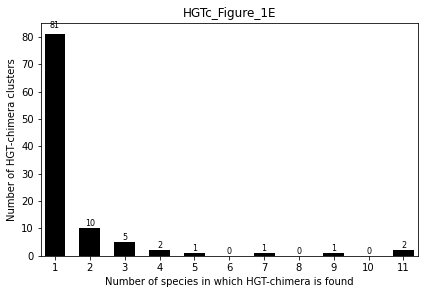

In [45]:
m=dict(Counter(list(df.n_species[1:])))
for i in range(1,int(max(m.keys()))+1):

    if i not in m:
        m[i]=0

cats     = m.keys()   # x-positions (0, 1, 2…)
heights  = m.values()         # bar heights

# ----------------------------------------------------------
# 3.  Figure sizing:  0.4 inch per bar (min 4 in wide)
# ----------------------------------------------------------
    # scale width to #bars
fig, ax   = plt.subplots()

# ----------------------------------------------------------
# 4.  Draw bars (default colour) and annotate the taller ones
# ----------------------------------------------------------
bars = ax.bar(cats, heights, width=0.6,color='black')    # narrower bars for many cats



for bar, h in zip(bars, heights):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h * 1.02,                      # 2 % above bar top
        f"{int(h)}",
        ha="center",
        va="bottom",
        fontsize=8
    )

# ----------------------------------------------------------
# 5.  Axes cosmetics
# ----------------------------------------------------------
ax.set_xlabel('Number of species in which HGT-chimera is found')
ax.set_ylabel('Number of HGT-chimera clusters')
l=list(cats)
l.sort()

ax.set_xticks(l)
    # avoids overlap when many bars
ax.margins(x=0.01)                         # tiny horizontal padding

plt.tight_layout()
plt.title('HGTc_Figure_1E')
plt.savefig('figures/HGTc_Figure_1E.svg',format='svg')
plt.show()

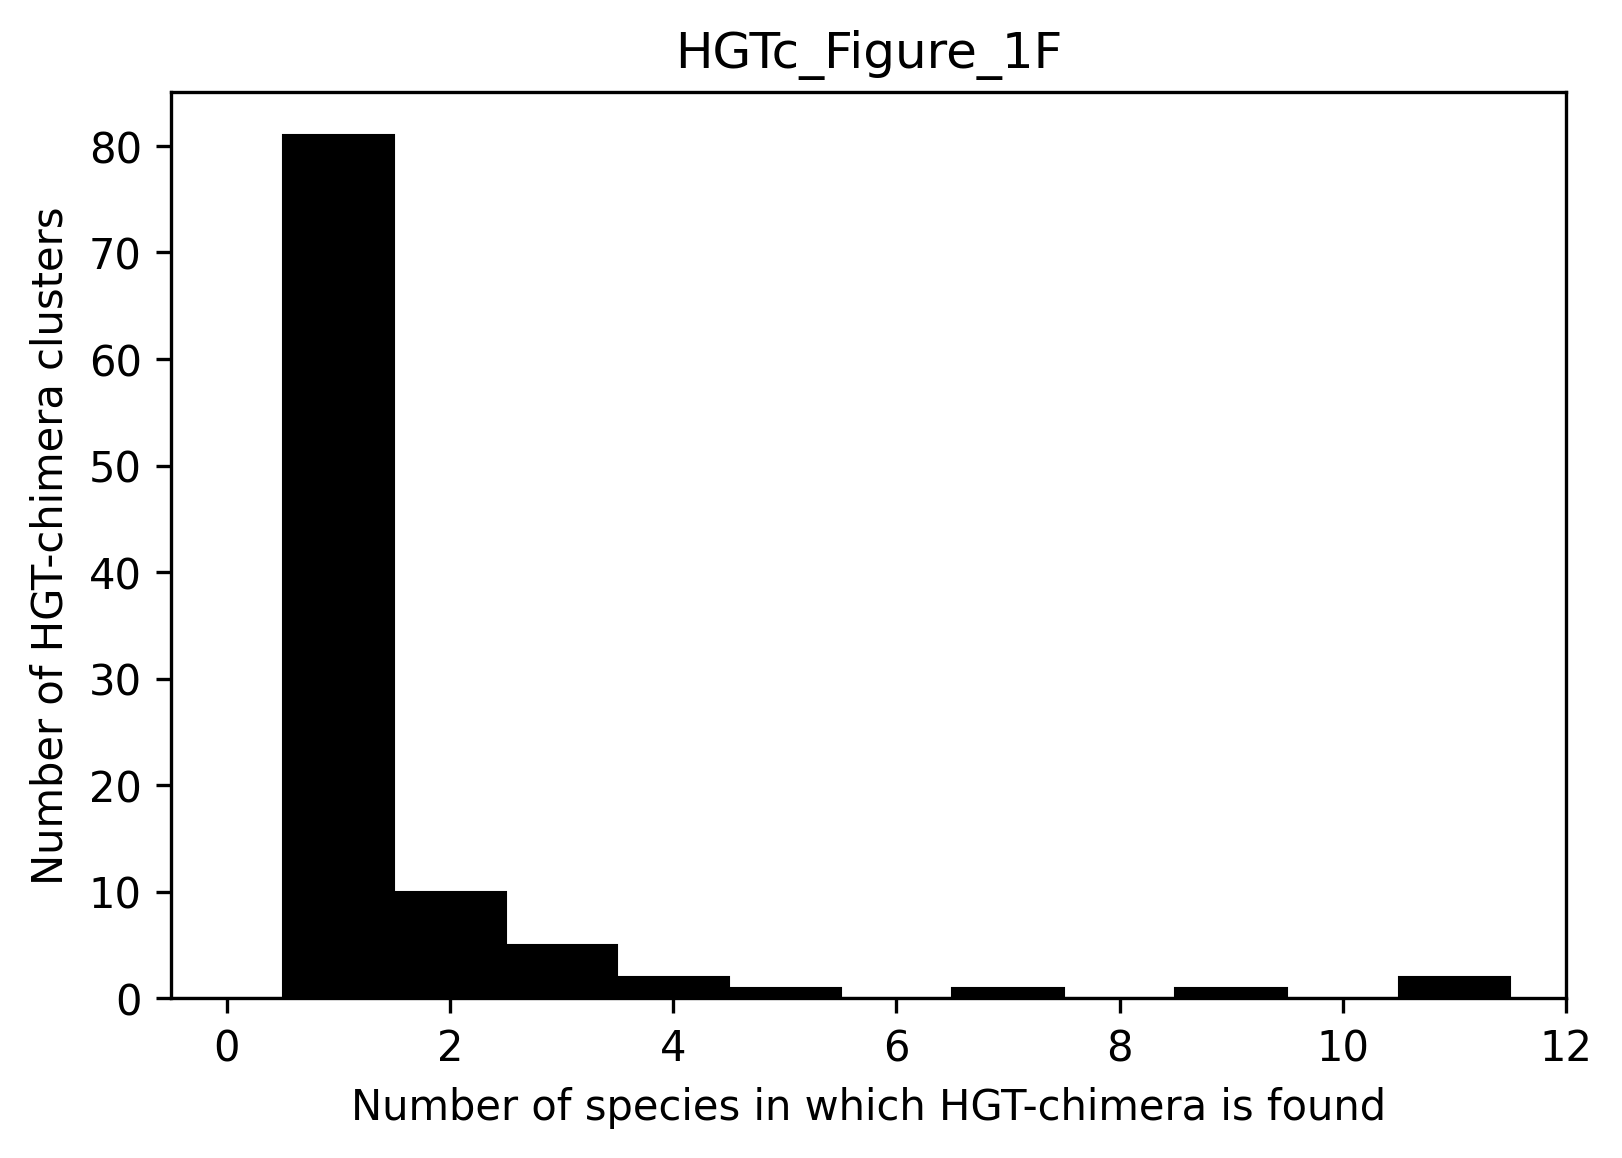

In [66]:
import numpy as np
l=list(df.n_species[1:])

# ─── 2. integer-aligned histogram bins ───────────────────────────────────────
bins = np.arange(0, max(l) + 2) - 0.5      # centres bars on integers

plt.hist(
    l,
    bins=bins,
    color='black',
    rwidth=1,          # 60 % of full bin width
    edgecolor='black',   # draw borders around bars
    linewidth=0.5        # thin border line
)

plt.xlim(-0.5, 12)
plt.xlabel('Number of species in which HGT-chimera is found')
plt.ylabel('Number of HGT-chimera clusters')
plt.title("HGTc_Figure_1F")
plt.savefig("figures/HGTc_Figure_1F.svg",format='svg')

## SI Figure 5A: distribution of clusters across taxonomic ranks

In [69]:
from collections import defaultdict
tax_ranks=['clade','phylum','subclass','infraclass', 'order','infraorder', 'superfamily', 'family','tribe','genus','species','subspecies']
rank_count=defaultdict(int)
for t in tax_ranks:
    if t=='clade':
        rank_count['unranked clade']=len([x for x in df['span_rank'] if x==t])
    elif 'species' in t:
        rank_count['species/subspecies']+=len([x for x in df['span_rank'] if x==t])
    else:
        rank_count[t]=len([x for x in df['span_rank'] if x==t])

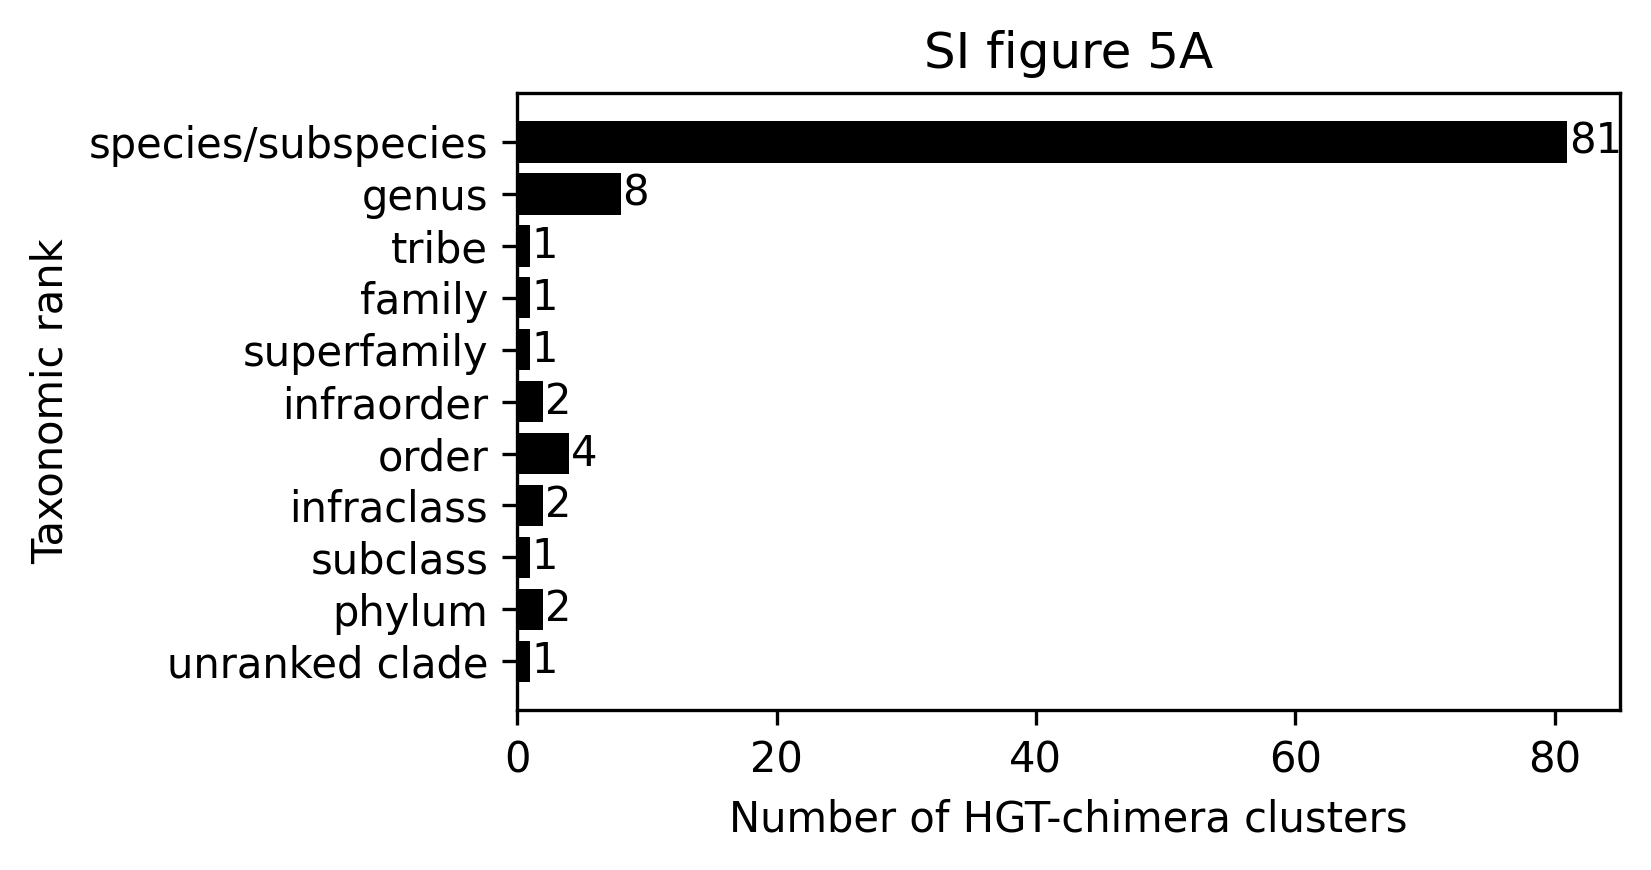

In [70]:
fig, ax = plt.subplots(figsize=(5.6, 3)) 

bars = ax.barh(
    list(rank_count.keys()),   # y-positions / labels
    list(rank_count.values()), # bar lengths
    color='black'
)

# Add a number at the end of every bar
for bar in bars:
    width = bar.get_width()                         # numeric value
    y_pos = bar.get_y() + bar.get_height() / 2      # bar’s vertical center
    ax.text(
        width + 0.1,                                # a small offset to the right
        y_pos,
        f'{width:.0f}',                             # format as integer
        va='center',
        ha='left'
    )

plt.xlabel('Number of HGT-chimera clusters')
plt.ylabel('Taxonomic rank')
plt.title('SI figure 5A')
plt.tight_layout()
plt.savefig('figures/SI figure 5A.svg',format='svg')

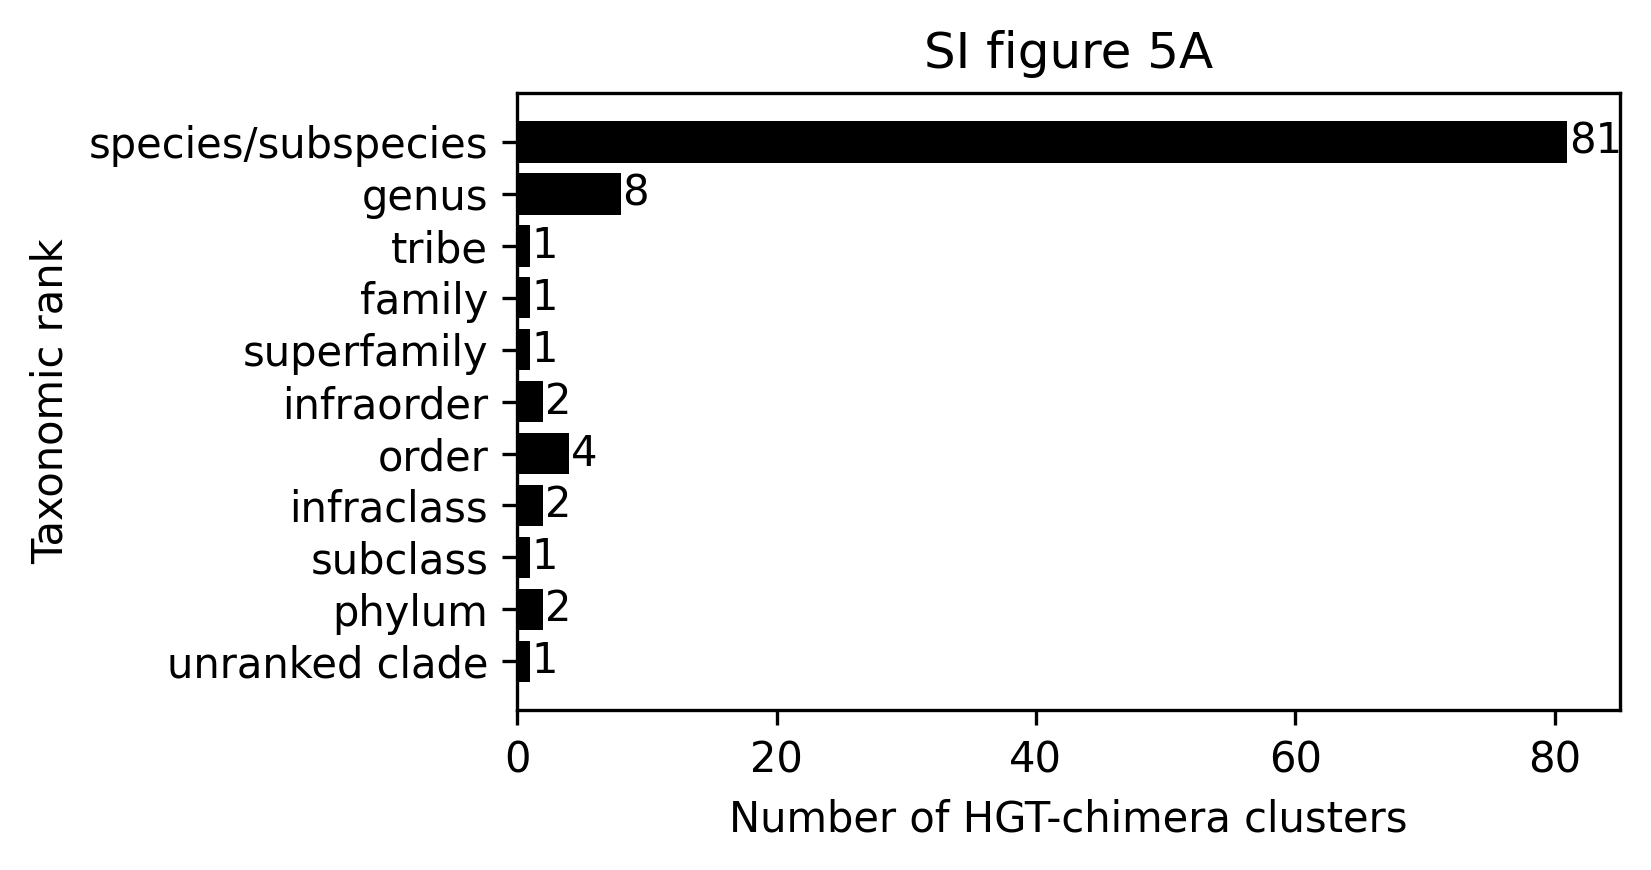

In [59]:
fig, ax = plt.subplots(figsize=(5.6, 3)) 

bars = ax.barh(
    list(rank_count.keys()),   # y-positions / labels
    list(rank_count.values()), # bar lengths
    color='black'
)

# Add a number at the end of every bar
for bar in bars:
    width = bar.get_width()                         # numeric value
    y_pos = bar.get_y() + bar.get_height() / 2      # bar’s vertical center
    ax.text(
        width + 0.1,                                # a small offset to the right
        y_pos,
        f'{width:.0f}',                             # format as integer
        va='center',
        ha='left'
    )

plt.xlabel('Number of HGT-chimera clusters')
plt.ylabel('Taxonomic rank')
plt.title('SI figure 5A')
plt.tight_layout()
plt.savefig('figures/SI figure 5A.svg',format='svg')

## SI table 2: all primary and secondary chimeras
with intervals, cluster assignments, and taxonomic chimeras

In [81]:
##load information on whether intervals are blast or hmmer assigned
import pickle
file_path = 'outputs/clustered_ankyrin_transposon_secondary_filtered_chimeras.pickle'
with open(file_path, 'rb') as file:
    chimeras=pickle.load(file)
##append to intervals
intervals=[]
for c in chimeras:
    for i in chimeras[c]:
        intervals.append(c+";"+chimeras[c][i]+"_"+str(i).replace(" ",""))
##extract sequences that have only self blast-hits (bit-score>min(bit-score non-arthropod))
##these are assumed to have 0 secondary chimeras  and blast hits instead of hmmsearch hits are used for phylogenetic dataset contstruction
blast_hits=[]
for chimera in chimeras:
    ints=[x for x in intervals if chimera in x]
    for x in ints:
        a2=SeqIO.to_dict(SeqIO.parse(f'outputs/hmmbuild/{chimera}/{x}/sub_seq.fasta', 'fasta'))
        if len(a2.keys())<=1:
       
            blast_hits.append(x)
hmmer_hits=set(intervals)-set(blast_hits)

##get intervals from phylogenetically confirmed hgt/metazoan
hgt_intervals=set(hgt.index)
meta_intervals=set(meta.index)

In [82]:
from collections import defaultdict

In [86]:
df_all=pd.DataFrame()
for cluster, row in df.iterrows():
    q=row.q_name
    
    
    hgts=[x for x in hgt_intervals if q in x]
    metas=[x for x in meta_intervals if q in x]
    hgt_map=defaultdict(list)
    meta_map=defaultdict(list)
    
    ## add all hgt and metazoan intervals for secondary chimeras from blast/hmmer results
    for interv in hgts:
        
      
        if interv in hmmer_hits:
            arth = pd.read_csv(f"outputs/hmmsearch_v_arthropod/{interv}.tsv", sep="\t")
            arth=arth[arth.target_name.isin(secondary_chimera_adjacency_list[q])]
            arth=arth[arth.target_name!=q]
            arth=arth.loc[arth.groupby('target_name')['domain_score'].idxmax()]
        
            for index, row in arth.iterrows():
                hgt_map[row.target_name].append(str((row['envfrom'],row['envto'])))
           
        else:
            arth = pd.read_csv(f"outputs/round2_diamond_v_arthropod_output_split/{interv}.tsv", sep="\t")
            arth=arth[arth.sseqid.isin(secondary_chimera_adjacency_list[q])]
            arth=arth[arth.sseqid!=q]
            arth=arth.loc[arth.groupby('sseqid')['bitscore'].idxmax()]
            for index, row in arth.iterrows():
                hgt_map[row.stitle].append(str((row['sstart'],row['send'])))
    for interv in metas:
        if interv in hmmer_hits:
            arth = pd.read_csv(f"outputs/hmmsearch_v_arthropod/{interv}.tsv", sep="\t")
            arth=arth[arth.target_name.isin(secondary_chimera_adjacency_list[q])]
            arth=arth[arth.target_name!=q]
            arth=arth.loc[arth.groupby('target_name')['domain_score'].idxmax()]
            for index, row in arth.iterrows():
                meta_map[row.target_name].append(str((row['envfrom'],row['envto'])))
        else:
            arth = pd.read_csv(f"outputs/round2_diamond_v_arthropod_output_split/{interv}.tsv", sep="\t")
            arth=arth[arth.sseqid.isin(secondary_chimera_adjacency_list[q])]
            arth=arth[arth.sseqid!=q]
            arth=arth.loc[arth.groupby('sseqid')['bitscore'].idxmax()]
            for index, row in arth.iterrows():
                meta_map[row.stitle].append(str((row['sstart'],row['send'])))
                
    df_all.loc[q,['cluster','HGT_intervals','Metazoan_intervals',"representative"]]=cluster, str([str(x.split("_")[-1]) for x in hgts]).replace("'",""),str([str(x.split("_")[-1]) for x in metas]).replace("'",""),True
    for n in meta_map:
        df_all.loc[n,['cluster','HGT_intervals','Metazoan_intervals',"representative"]]=cluster, str(hgt_map[n]).replace("'",""),str(meta_map[n]).replace("'",""),False
  


In [87]:
## for the primary chimera GCF_002204515.2;XP_021699539.1, each of the 3 HGT intervals are hmmer hits to each other
## this causes a redundancy in the last two hgt intervals in the secondary chimera 'GCF_006496715.1;XP_029735553.1' which we manually correct
## by manually selecting a hmmer hit range for the last range
print(df_all.loc['GCF_006496715.1;XP_029735553.1',:].HGT_intervals)
for interv in [x for x in intervals if 'GCF_002204515.2;XP_021699539.1' in x if 'HGT' in x]:
    q='GCF_002204515.2;XP_021699539.1'
    arth = pd.read_csv(f"outputs/hmmsearch_v_arthropod/{interv}.tsv", sep="\t")
    arth=arth[arth.target_name.isin(secondary_chimera_adjacency_list[q])]
    arth=arth[arth.target_name!=q]
    # arth=arth.loc[arth.groupby('target_name')['domain_score'].idxmax()]
    for index, row in arth.iterrows():
        if 'XP_029735553.1' in row.target_name:
            print(interv,str((row['envfrom'],row['envto'])),row['domain_score'])
df_all.loc['GCF_006496715.1;XP_029735553.1','HGT_intervals']=str([(183, 310), (4, 147), (374, 517)])

[(183, 310), (4, 147), (8, 152)]
GCF_002204515.2;XP_021699539.1;HGT_(5,150) (377, 506) 93.5
GCF_002204515.2;XP_021699539.1;HGT_(5,150) (1044, 1080) -3.9
GCF_002204515.2;XP_021699539.1;HGT_(5,150) (183, 310) 96.6
GCF_002204515.2;XP_021699539.1;HGT_(190,334) (4, 147) 168.1
GCF_002204515.2;XP_021699539.1;HGT_(190,334) (174, 317) 167.1
GCF_002204515.2;XP_021699539.1;HGT_(190,334) (369, 509) 99.4
GCF_002204515.2;XP_021699539.1;HGT_(385,523) (8, 152) 151.9
GCF_002204515.2;XP_021699539.1;HGT_(385,523) (179, 320) 106.8
GCF_002204515.2;XP_021699539.1;HGT_(385,523) (374, 517) 136.6


In [143]:
## fill in taxonomic information for each chimera
for index, row in df_all.iterrows():
    df_all.loc[index,['species','taxid','order','class']]=list(dftax.loc[index.split(";")[0],['Organism Name','Organism Taxonomic ID','order','class']])

In [92]:
## load unique gene/locus identifier per gene from stored gff files 
df_all['protein']=[x.split(";")[1] for x in df_all.index]
for index, row in df_all.iterrows():
    
    genome=index.split(";")[0]
    try:
        gff=pd.read_csv(f'/n/netscratch/extavour_lab/Everyone/Rishabh/ncbi_dataset1/data/{genome}/genomic.gff',sep='\t',comment='#',header=None)
        gff=gff[gff[2]=='CDS']
        try:
            gene=gff[gff[8].str.contains(index.split(";")[1])].iloc[0,8].split("gene=")[1].split(";")[0]
        except:
            gene=gff[gff[8].str.contains(index.split(";")[1])].iloc[0,8].split("locus_tag=")[1].split(";")[0]
        df_all.loc[index,'gene']=gene
    except:
        print(genome)
df_all.loc['GCF_006496715.1;XP_029735553.1','gene']='LOC109414258' 

GCF_006496715.1


In [163]:
df_all['genome']=[x.split(';')[0] for x in df_all.index]
df=df_all
df=pd.read_csv("SI tables/SI table 2.tsv",sep="\t",index_col=0)
df['species_cluster']=[str(x)+";"+str(y) for x,y in zip(df.cluster,df.taxid)]
import ast
for index, row in df.iterrows():
    h=ast.literal_eval(row.HGT_intervals)
    for x in range(len(h)):
        df.loc[index,f"HGT_interval_{x+1}"]=str(h[x])
     
    h=ast.literal_eval(row.Metazoan_intervals)
    for x in range(len(h)):
        df.loc[index,f"Metazoan_interval_{x+1}"]=str(h[x])
df['data_source']=['RefSeq' if 'GCF_' in x else 'GenBank' for x in df['genome']]
df.to_csv("SI tables/SI table 2.tsv",sep="\t")

## SI table 6 phylostratigraphic age
Outputs a table of all chimeras found in more than one species for phylostratigraphic ages

In [167]:
SI6=df[df.n_species>1].loc[:,['n_species','span_name','span_rank','all_species']]

In [168]:
SI6.columns=["n_species","Distribution","Rank","all_species"]

In [169]:
SI6.to_csv("SI tables/SI table 6.tsv",sep="\t")

## Supplementary table 3: chimeras per species
For each species, records the unique chimera clusters found in its genome, along with all protein accessions 

In [165]:
df_species=pd.DataFrame()
species_count={}
for s in set(dftax['Organism Taxonomic ID']):

    df_species.loc[s,'species']=dftax[dftax['Organism Taxonomic ID']==s]['Organism Name'].values[0]
    df_species.loc[s,'in_primary_search_set']='GCF_' in dftax[dftax['Organism Taxonomic ID']==s].index.values[0]
    df_species.loc[s,'in_primary_search_set']='GCF_' in dftax[dftax['Organism Taxonomic ID']==s].index.values[0]
    df_species.loc[s,['class','order']]=dftax[dftax['Organism Taxonomic ID']==s].loc[:,['class','order']].values[0]
    
    ds=df_all[df_all.taxid==s]
    if ds.shape[0]>0:
        l=list(set(ds.cluster))
        g=list(set(ds.gene))
        l.sort()
        df_species.loc[s,'chimera_clusters']=str(l)
        df_species.loc[s,'n_chimera_clusters']=len(l)
        df_species.loc[s,'n_chimera_genes']=len(g)
        df_species.loc[s,'chimera_proteins']=str(set([str(y)+f' ({x})' for x,y in zip(ds.cluster,ds.protein)]))


In [166]:
df_species.index.name='taxid'
df_species['n_chimera_clusters']=df_species['n_chimera_clusters'].fillna(0)
df_species=df_species.sort_values('n_chimera_clusters',ascending=False)
df_species.to_csv("SI tables/SI table 3.tsv",sep="\t")

## Figure 1C: HGTc/genome

In [11]:
df_species=pd.read_csv("SI tables/SI table 3.tsv",sep="\t")

In [36]:
193/319

0.6050156739811913

In [34]:
di=df_species[df_species.in_primary_search_set]
di[di['n_chimera_clusters']>0].shape[0]

193

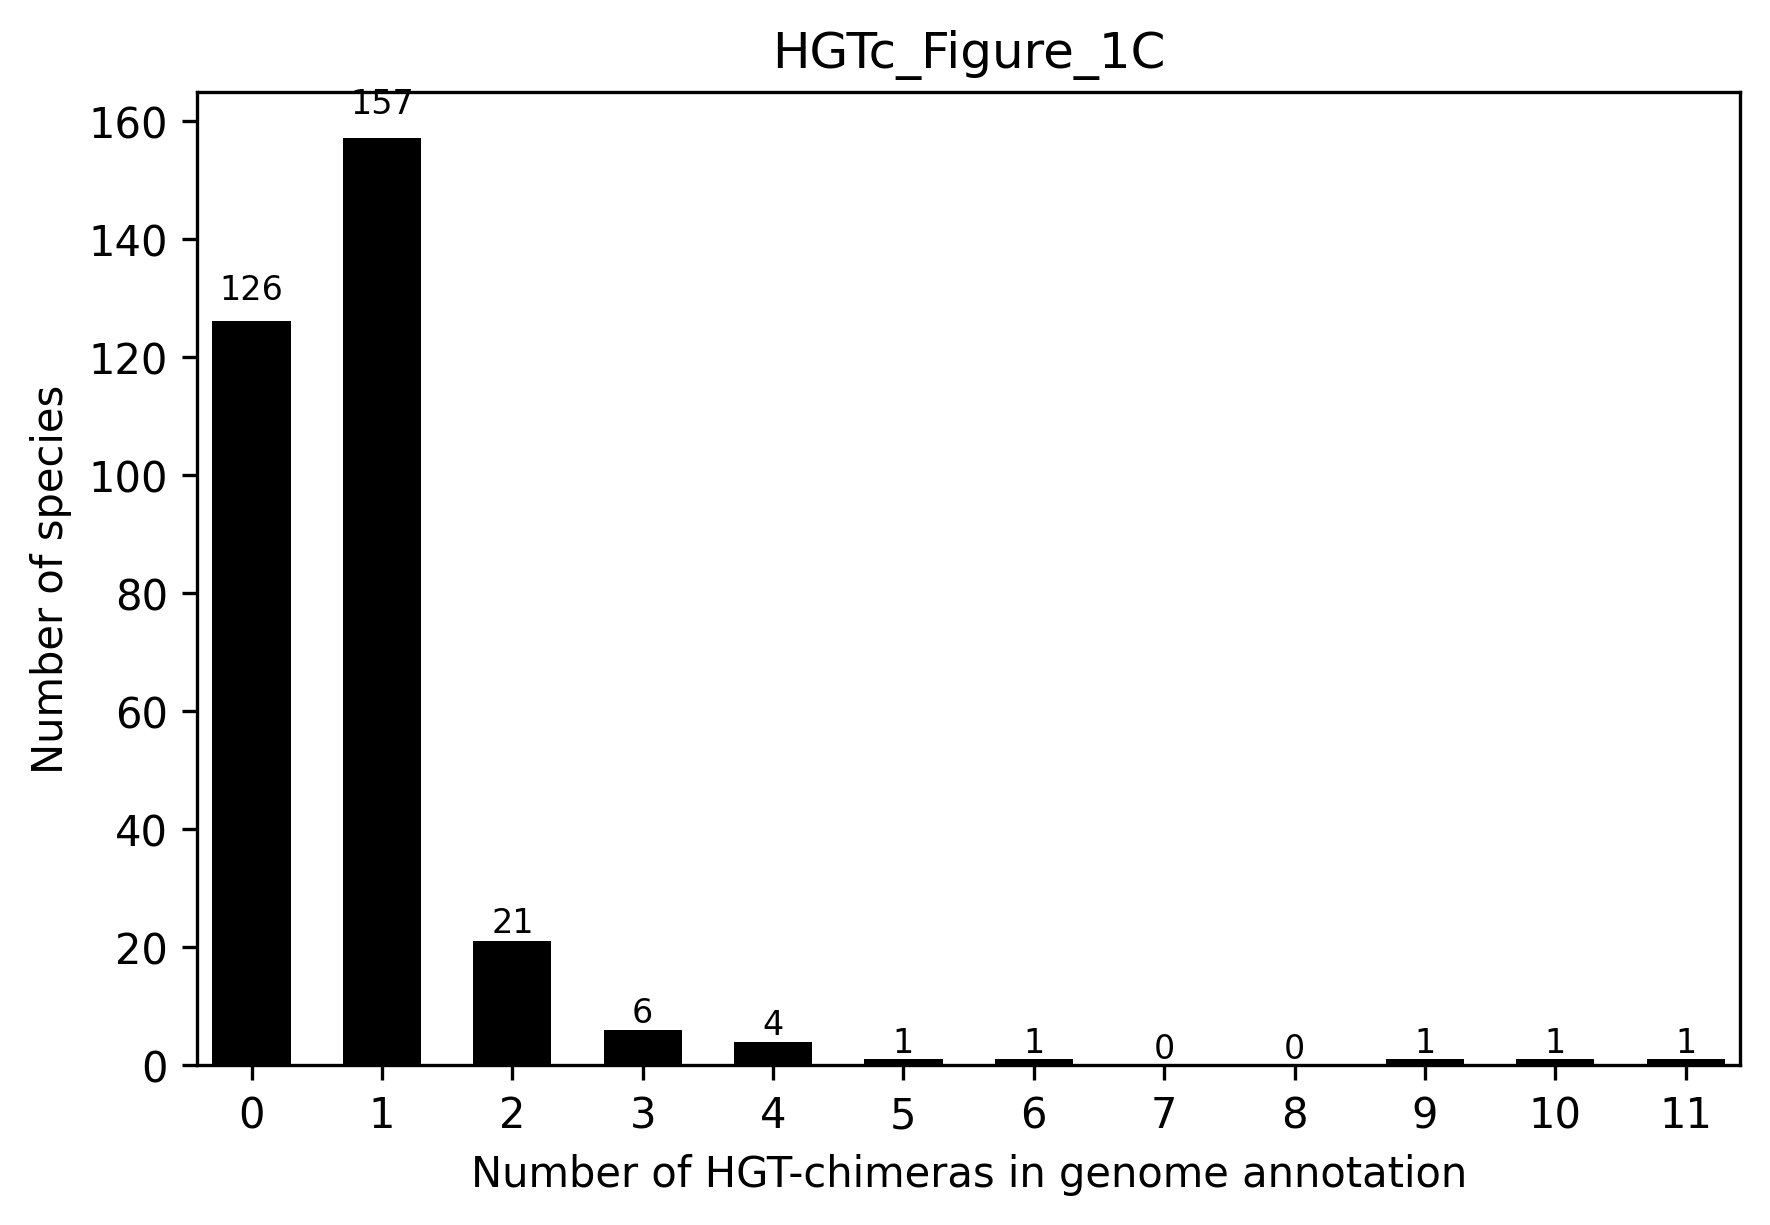

In [126]:
from collections import Counter
counts=list(df_species[df_species.in_primary_search_set]['n_chimera_clusters'])
m=dict(Counter(counts))
for i in range(0,int(max(m.keys()))+1):

    if i not in m:
        m[i]=0

cats     = m.keys()   # x-positions (0, 1, 2…)
heights  = m.values()         # bar heights

# ----------------------------------------------------------
# 3.  Figure sizing:  0.4 inch per bar (min 4 in wide)
# ----------------------------------------------------------
    # scale width to #bars
fig, ax   = plt.subplots()

# ----------------------------------------------------------
# 4.  Draw bars (default colour) and annotate the taller ones
# ----------------------------------------------------------
bars = ax.bar(cats, heights, width=0.6,color='black')    # narrower bars for many cats



for bar, h in zip(bars, heights):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h * 1.02,                      # 2 % above bar top
        f"{int(h)}",
        ha="center",
        va="bottom",
        fontsize=8
    )

# ----------------------------------------------------------
# 5.  Axes cosmetics
# ----------------------------------------------------------
ax.set_xlabel("Number of HGT-chimeras in genome annotation")
ax.set_ylabel("Number of species")
l=list(cats)
l.sort()

ax.set_xticks(l)
    # avoids overlap when many bars
ax.margins(x=0.01)                         # tiny horizontal padding

plt.tight_layout()
plt.title('HGTc_Figure_1C')
plt.savefig('figures/HGTc_Figure_1C.svg',format='svg')
plt.show()


In [1]:
157+2*21+3*6+4*4+5+6+9+10+11

274

## Figure 1 D-E: order-level phylogram
Prepares data for a phylogram showing the number of unique chimeras per taxonomic order (at most one representative of each chimera cluster per species)

In [9]:
df_all['species_cluster']=[str(x)+"_"+str(y) for x,y in zip(df_all['cluster'],df_all['taxid'])]
df_order=pd.DataFrame()
for o in set(df_all.order):
    ds=df_all[df_all.order==o]
    df_order.loc[o,'N_chimeras']=len(set(ds.species_cluster))
    df_order.loc[o,'N_chimeras_no_oskar']=len(set([x for x in ds.species_cluster if x.split("_")[0]!='1']))
df_order['N_chimeras'].sum()

348.0

In [150]:
df_all['species_cluster']=[str(x)+"_"+str(y) for x,y in zip(df_all['cluster'],df_all['taxid'])]
df_order=pd.DataFrame()
for o in set(df_all.order):
    ds=df_all[df_all.order==o]
    df_order.loc[o,'N_chimeras']=len(set(ds.species_cluster))
    df_order.loc[o,'N_chimeras_no_oskar']=len(set([x for x in ds.species_cluster if x.split("_")[0]!='1']))
df_order

,N_chimeras,N_chimeras_no_oskar
Thysanoptera,2.0,2.0
Hymenoptera,70.0,7.0
Phasmatodea,4.0,3.0
Ephemeroptera,1.0,0.0
Anostraca,2.0,2.0
Diptera,123.0,20.0
Diplostraca,16.0,16.0
Entomobryomorpha,15.0,15.0
Ixodida,5.0,5.0
Lepidoptera,14.0,14.0


In [152]:
import ete3
from ete3 import Tree
## add order counts to a phylogram 
t=Tree("(((((((((((Allomalorhagida)Kinorhyncha,(Priapulimorphida)Priapulida)Scalidophora,(((Chordodea)Gordioida)Nematomorpha,((Rhabditida,Desmodorida,Chromadorida,Plectida)Chromadorea,((Dioctophymatida,Trichinellida)Dorylaimia,(Triplonchida,Enoplida)Enoplia)Enoplea)Nematoda)Nematoida,((((Echiniscoidea)Heterotardigrada,(Parachela,Apochela)Eutardigrada)Tardigrada,(((Euonychophora)Udeonychophora)Onychophora,(((Pantopoda)Pycnogonida,(Xiphosura)Merostomata,(Pseudoscorpiones,Opiliones,Solifugae,((Scorpiones,((Araneae,(Amblypygi,Uropygi))Tetrapulmonata))Arachnopulmonata),((Ixodida,Mesostigmata)Parasitiformes,(Sarcoptiformes,Trombidiformes)Acariformes)Acari)Arachnida)Chelicerata,((Symphyla,(Tetramerocerata)Pauropoda,((Scutigeromorpha)Notostigmophora,(Lithobiomorpha,Craterostigmomorpha,(Geophilomorpha,Scolopendromorpha)Epimorpha)Pleurostigmophora)Chilopoda,((Polyxenida)Penicillata,(Glomerida)Pentazonia,(Julida,Callipodida,Chordeumatida,Polyzoniida,Polydesmida)Helminthomorpha)Diplopoda)Myriapoda,((((Arguloida)Branchiura)Ichthyostraca,((Podocopida)Podocopa,(Myodocopida)Myodocopa)Ostracoda)Oligostraca,((((((Scalpellomorpha,Balanomorpha,Pollicipedomorpha)Thoracicalcarea)Thoracica)Cirripedia)Thecostraca,((((Calanoida)Gymnoplea,(Siphonostomatoida,Harpacticoida,Cyclopoida,Polyarthra)Podoplea)Neocopepoda)Copepoda)Hexanauplia,((Leptostraca)Phyllocarida,((Stomatopoda)Hoplocarida,(Anaspidacea)Syncarida,(Euphausiacea,Decapoda)Eucarida,(Amphipoda,Tanaidacea,Isopoda,(Mysida)Mysidacea)Peracarida)Eumalacostraca)Malacostraca)Multicrustacea,(((Anostraca)Sarsostraca,(Notostraca,Diplostraca)Phyllopoda)Branchiopoda,(((Nectiopoda))Remipedia,(Protura,((Poduromorpha,Entomobryomorpha,Symphypleona)Collembola,(Diplura,((Archaeognatha)Monocondylia,(Zygentoma,((Odonata,Ephemeroptera)Palaeoptera,(((Dermaptera,Zoraptera),(Plecoptera,(Orthoptera,((Mantodea,Blattodea)Dictyoptera,((Grylloblattodea,Mantophasmatodea),(Phasmatodea,(Embioptera)))))))Polyneoptera,((Thysanoptera,Hemiptera)Condylognatha,((Phthiraptera,Psocoptera)Psocodea,(Hymenoptera,(((Trichoptera,Lepidoptera)Amphiesmenoptera,(Diptera,(Siphonaptera,Mecoptera))),((Coleoptera,(Strepsiptera)),(Raphidioptera,(Neuroptera,Megaloptera))Neuropterida)))Endopterygota)))Neoptera)Pterygota)Dicondylia)Insecta))Hexapoda)))))Pancrustacea)Mandibulata)Arthropoda)Antennopoda)Panarthropoda)Panarthropoda)Ecdysozoa)Protostomia)Bilateria)Eumetazoa)Metazoa)Opisthokonta)Eukaryota)cellular_organisms);",format=1)
keep=set(df_order.index)
t.prune(keep, preserve_branch_length=True)
for leaf in t.iter_leaves():
    
    leaf.name = leaf.name+str(int(df_order.loc[leaf.name,'N_chimeras']))+'_'+str(int(df_order.loc[leaf.name,'N_chimeras_no_oskar']))
t.write() 

'(((Ixodida5_5:2,Sarcoptiformes21_21:2)1:1,Araneae1_1:5)1:2,((((Siphonostomatoida1_1:1,Harpacticoida4_4:1)1:1,Calanoida10_10:2)1:3,Decapoda14_14:4)1:1,((Anostraca2_2:2,Diplostraca16_16:2)1:1,((Entomobryomorpha15_15:1,Symphypleona1_1:1)1:1,((Odonata2_2:1,Ephemeroptera1_0:1)1:1,(((Thysanoptera2_2:1,Hemiptera9_9:1)1:1,(Hymenoptera70_7:1,((Lepidoptera14_14:2,Diptera123_20:2)1:1,Coleoptera28_18:3)1:1)1:2)1:1,(Orthoptera4_2:1,(Blattodea1_0:2,Phasmatodea4_3:3)1:1)1:3)1:1)1:4)1:3)1:1)1:3);'

## SI table 5: gene copy number per orthologous cluster

In [175]:
df_gene_copies=pd.DataFrame()
for genome in set(df_all.genome):
    s=df_all[df_all.genome==genome]
    species=s.species.values[0]
    clusters=set(s.cluster)
    for c in clusters:
        df_gene_copies.loc[genome,['species','cluster','n_genes','genes']]=species,c,len(set(s[s.cluster==c].gene)),str(set(s[s.cluster==c].gene))

In [181]:
df_gene_copies.to_csv('SI tables/SI table 5.tsv',sep='\t')

## SI Figure 4: class level phylogram
a class level phylogram focusing on genomes in the primary search set, outputting pie charts with the fraction of genomes with at least one hgt-chimera, the total number of genomes searched, and the number of chimera orthologous clusters found

In [154]:
##primary search set of refseq genomes
dfsearch=dftax[dftax.index.str.contains('GCF')]
classes=set(dfsearch['class'])
##chimeras recovered in primary/refseq genomes
chimeras=df_all[df_all.index.str.contains('GCF')]


In [155]:
data=pd.DataFrame()
for x in classes:
    genomes=set(dfsearch[dfsearch['class']==x]['Organism Taxonomic ID'].astype(int))
    genomes_chimeras=set(chimeras[chimeras['class']==x].taxid)
    clusters=len(set(chimeras[chimeras['class']==x].cluster))
    data.loc[x,["n_searched","n_w_chimera", "n_no_chimera","n_clusters"]]=len(genomes), len(genomes_chimeras), len(genomes-genomes_chimeras),clusters

In [158]:
f=open('itol_piechart_template.txt','a')
for index, row in data.iterrows():
    n_w=row['n_w_chimera']
    n_n=row['n_no_chimera']
    f.write(f"{index},-1,10,{n_w},{n_n}\n")
f.close()

In [160]:
data

,n_searched,n_w_chimera,n_no_chimera,n_clusters
Arachnida,19,7,12,17
Merostomata,1,0,1,0
Thecostraca,1,0,1,0
Hexanauplia,3,3,0,13
Collembola,1,1,0,11
Branchiopoda,5,5,0,8
Insecta,273,168,105,56
Malacostraca,16,9,7,2
